In [1]:
import re
import os
import string

%matplotlib inline

import numpy as np
import pandas as pd
import pylab as P
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.lancaster import LancasterStemmer
from collections import Counter
import networkx as nx
from nxpd import draw

plt.style.use('ggplot')
plt.rcParams['font.size'] = 15
pd.set_option('max_colwidth',30)

## Read the emails files in allen-p folder and build dataframe

In [2]:
# To extract five data: email from, enail to, subject, email text, sent date
def read_email(path):
    from_list = []
    to_list = []
    subject_list = []
    date_list = []
    text_list = []

    # Regular expression to extract data
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r') as content_file:
            content = content_file.read()
            # From
            from_list.append(re.findall('[\n\r].*From: \s*([^\n\r]*)', content)[0])
            # To
            to_list.append(re.findall('[\n\r].*To: \s*([^\n\r]*)', content)[0])
            # Subject
            subject = re.findall('Subject: (?s)(.*)Mime-Version', content)[0]
            subject = subject.replace('\n', '')
            subject_list.append(subject)
            # Date
            date_list.append(re.findall('[\n\r].*Date: \s*([^\n\r]*)', content)[0])
            # Email text
            text_original = re.findall("(?<=X-FileName:)[.|\n|\W|\w]*", content)[0]
            text = text_original.replace('\n', '')
            text = text.replace('pallen (Non-Privileged).pst', '')
            text = text.replace('pallen.nsf', '')
            text_list.append(text)

    # Using 5 lists to build Pandas DataFrame
    email_data = {'From': from_list, 'To': to_list, 'Subject': subject_list, 'Date': date_list, 'Text': text_list}
    df = pd.DataFrame(email_data, columns=['From', 'To', 'Subject', 'Date', 'Text'])
    # Change "" in df to NaN
    df = df.replace('', np.nan, regex=True)
    return df

# Read email from folders to dataframes
df_allenp = read_email('enron/allen-p/_sent_mail/')
df_campbell = read_email('enron/campbell-l/_sent_mail/')
df_donoho = read_email('enron/donoho-l/sent_items/')
df_kuykendallt = read_email('enron/kuykendall-t/_sent_mail/')
df_mcconnellm = read_email('enron/mcconnell-m/_sent_mail/')
df_mckayj = read_email('enron/mckay-j/sent_items/')

## The first 5 rows in every DataFrame, with 5 columns

In [3]:
df_allenp.head()

,From,To,Subject,Date,Text
0,phillip.allen@enron.com,tim.belden@enron.com,NaN,"Mon, 14 May 2001 16:39:00 ...",Here is our forecast
1,phillip.allen@enron.com,john.lavorato@enron.com,Re:,"Fri, 4 May 2001 13:51:00 -...",Traveling to have a busin...
2,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,"Wed, 18 Oct 2000 03:00:00 ...",test successful. way to ...
3,phillip.allen@enron.com,randall.gay@enron.com,NaN,"Mon, 23 Oct 2000 06:13:00 ...","Randy, Can you send me a ..."
4,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"Thu, 31 Aug 2000 05:07:00 ...",Let's shoot for Tuesday a...


In [4]:
df_donoho.head()

,From,To,Subject,Date,Text
0,lindy.donoho@enron.com,audrey.robertson@enron.com,Hand-outs for 9:00 Dry Run...,"Thu, 25 Oct 2001 16:01:01 ...",LDONOHO (Non-Privileged)....
1,lindy.donoho@enron.com,lachandra.fenceroy@enron.c...,FW: Bus Applications Meeti...,"Mon, 22 Oct 2001 07:53:01 ...",LDONOHO (Non-Privileged)....
2,lindy.donoho@enron.com,michael.ratner@enron.com,Slide #11Cc: steven.harris...,"Tue, 12 Feb 2002 10:59:08 ...",ldonoho (Non-Privileged)....
3,lindy.donoho@enron.com,michael.ratner@enron.com,RE: Slide #11,"Tue, 12 Feb 2002 12:28:33 ...",ldonoho (Non-Privileged)....
4,lindy.donoho@enron.com,michael.ratner@enron.com,Slide #24,"Wed, 13 Feb 2002 09:20:01 ...",ldonoho (Non-Privileged)....


In [5]:
df_campbell.head()

,From,To,Subject,Date,Text
0,larry.campbell@enron.com,"rick.loveless@enron.com, m...",Weekly Environemtnal Activ...,"Mon, 26 Nov 2001 10:10:00 ...",lcampbe.nsfThe third quar...
1,larry.campbell@enron.com,"rick.loveless@enron.com, m...",Weekly Envoironmental Acti...,"Thu, 11 Oct 2001 05:19:00 ...",lcampbe.nsfTranswestern P...
2,larry.campbell@enron.com,spendegr@enron.com,BTU factor,"Fri, 8 Sep 2000 08:20:00 -...",lcampbel.nsf-------------...
3,larry.campbell@enron.com,j.kinser@enron.com,Invitation,"Thu, 7 Sep 2000 06:29:00 -...",lcampbel.nsf-------------...
4,larry.campbell@enron.com,spendegr@enron.com,Deadlines for October tran...,"Thu, 7 Sep 2000 06:01:00 -...",lcampbel.nsf-------------...


## Have a look at the basic information in DataFrame
- 602 emails, 175 of which have no subjects

In [6]:
df_allenp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 0 to 601
Data columns (total 5 columns):
From       602 non-null object
To         602 non-null object
Subject    427 non-null object
Date       602 non-null object
Text       602 non-null object
dtypes: object(5)
memory usage: 16.5+ KB


## Look at each column
- phillip.allen used 2 email address, mostly "phillip.allen@enron.com"
- phillip.allen sent to 206 addresses, the most cotact is "stagecoachmama"
- phillip.allen sent 2 emails per day at most

In [7]:
df_allenp.describe()

,From,To,Subject,Date,Text
count,602,602,427,602,602
unique,2,206,323,593,580
top,phillip.allen@enron.com,stagecoachmama@hotmail.com,Re:,"Tue, 1 May 2001 07:14:00 -...",The topic will the the we...
freq,598,40,30,2,2


## To calsulate the frequencies of emails sent to

In [8]:
df_to = df_allenp.dropna(subset=['To'])

# select the top 20
df_allenp['To'].value_counts()[:20]

stagecoachmama@hotmail.com                       40
jsmith@austintx.com                              38
ina.rangel@enron.com                             37
pallen70@hotmail.com                             28
keith.holst@enron.com                            24
cbpres@austin.rr.com                             20
john.lavorato@enron.com                          16
maryrichards7@hotmail.com                        15
jacquestc@aol.com                                14
mike.grigsby@enron.com                           13
llewter@austin.rr.com                            10
rlehmann@yahoo.com                                8
stouchstone@natsource.com                         7
mike.grigsby@enron.com, keith.holst@enron.com     6
jeff.richter@enron.com                            6
matthew.lenhart@enron.com                         6
mac.d.hargrove@rssmb.com                          6
andrea.richards@enron.com                         6
al.pollard@enron.com                              5
gthorse@keya

## Extract features from email address
- domain name of each email address
- contact name or user name of each email address
- add 2 new columns

In [9]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern, flags=re.IGNORECASE)
organizations = []
contact = []
for email in df_allenp['To']:
    if regex.match(email):
        organizations.append(regex.match(email).groups()[1])
        contact.append(regex.match(email).groups()[0])
    else:
        organizations.append('')
        contact.append('')

df_allenp['ToOrganization'] = organizations
df_allenp['Contact'] = contact
df_allenp.head()

,From,To,Subject,Date,Text,ToOrganization,Contact
0,phillip.allen@enron.com,tim.belden@enron.com,NaN,"Mon, 14 May 2001 16:39:00 ...",Here is our forecast,enron,tim.belden
1,phillip.allen@enron.com,john.lavorato@enron.com,Re:,"Fri, 4 May 2001 13:51:00 -...",Traveling to have a busin...,enron,john.lavorato
2,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,"Wed, 18 Oct 2000 03:00:00 ...",test successful. way to ...,enron,leah.arsdall
3,phillip.allen@enron.com,randall.gay@enron.com,NaN,"Mon, 23 Oct 2000 06:13:00 ...","Randy, Can you send me a ...",enron,randall.gay
4,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"Thu, 31 Aug 2000 05:07:00 ...",Let's shoot for Tuesday a...,enron,greg.piper


## Calculate the most sent domain name
- may be the organization name

In [10]:
# select the top 20
df_allenp['ToOrganization'].value_counts()[:20]

enron                343
hotmail               87
austintx              38
austin.rr             32
aol                   14
yahoo                 12
natsource              7
intelligencepress      7
keyad                  7
rssmb                  6
caprock                4
creativepanel          4
thedoghousemail        3
webtv                  3
sempratrading          2
spbank                 2
pdq                    2
thermon                2
juno                   2
ev1                    2
Name: ToOrganization, dtype: int64

## Calculate the most contact person

In [11]:
# select the top 20
df_allenp['Contact'].value_counts()[:20]

stagecoachmama     40
jsmith             38
ina.rangel         38
mike.grigsby       30
keith.holst        28
pallen70           28
cbpres             22
john.lavorato      16
maryrichards7      15
jacquestc          14
matthew.lenhart    12
llewter            11
jeff.richter        9
rlehmann            8
stouchstone         7
andrea.richards     6
mac.d.hargrove      6
tim.belden          6
gthorse             6
frank.ermis         5
Name: Contact, dtype: int64

## Analyze email main text
- Process main text by Natural language processing
- Count the words frequencies
- The preparation for more analysis like sentiment analysis

In [12]:
# Randomly select text in one email
# Turn to lower case
email_text = df_allenp['Text'][500].lower()
# Remove punctuation
words = "".join([ch for ch in email_text if ch not in string.punctuation])
# Split the words
tokens = nltk.word_tokenize(words)
# Remove stop words
filtered = [w for w in tokens if not w in stopwords.words('english')]
# Code for stemming used in predition
# lanste = LancasterStemmer()
# stemmed = [lanste.stem(i) for i in filtered]

# Count top 10 used words
count = Counter(filtered)
count.most_common(10)

[('divert', 3),
 ('draft', 3),
 ('short', 2),
 ('sweet', 2),
 ('necessary', 2),
 ('pm', 2),
 ('comment', 2),
 ('opposition', 2),
 ('physically', 2),
 ('mbd', 2)]

## Select the most frequently contact "stagecoachmama"
- All emails between stagecoachmama and phillip.allen
- Count wodrs phillip.allen like to use in the emails to stagecoachmama

In [13]:
# Group the DataFrame by 'Contact' column and combine all text to 'stagecoachmama'
email_text = (" ").join(df_allenp.groupby('Contact')['Text'].apply(list)['stagecoachmama'])

# The same process as before
words = "".join([ch for ch in email_text if ch not in string.punctuation])
tokens = nltk.word_tokenize(words)
filtered = [w for w in tokens if not w in stopwords.words('english')]
# lanste = LancasterStemmer()
# stemmed = [lanste.stem(i) for i in filtered]
count = Counter(filtered)
words_used = count.most_common(20)
words_used

[('I', 68),
 ('rent', 23),
 ('need', 21),
 ('rentroll', 21),
 ('paid', 21),
 ('email', 17),
 ('Lucy', 17),
 ('get', 16),
 ('week', 13),
 ('file', 13),
 ('questions', 12),
 ('pay', 12),
 ('If', 12),
 ('The', 12),
 ('tenants', 12),
 ('missed', 11),
 ('You', 10),
 ('going', 10),
 ('LucyHere', 10),
 ('want', 10)]

## A simple visulization about last result

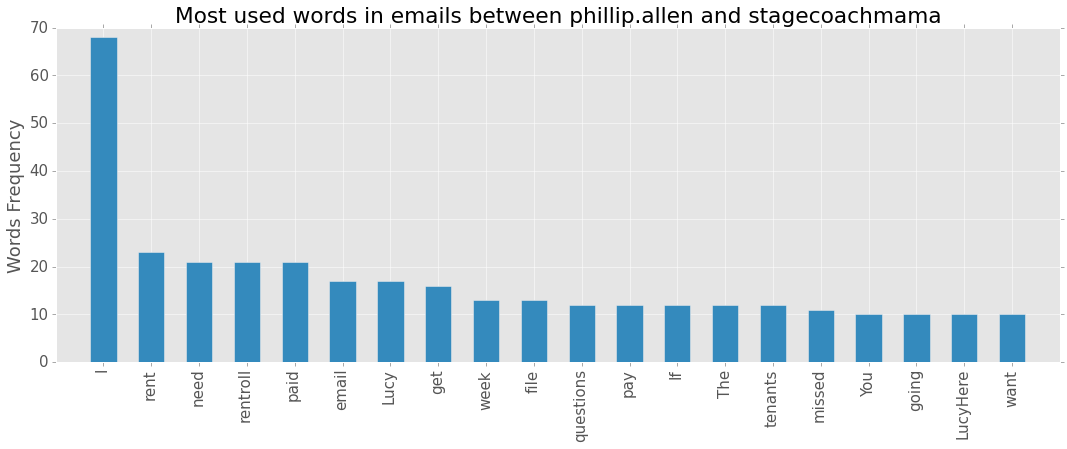

In [14]:
fig = plt.figure(figsize=(18,6), dpi=1600) 
x_val = [x[0] for x in words_used]
y_val = [x[1] for x in words_used]

ind = np.arange(len(x_val))

plt.bar(ind, y_val, width=0.55, align='center')
plt.xticks(ind, x_val, rotation='vertical')
plt.xlim(-1, 20)
plt.ylabel("Words Frequency")
plt.title("Most used words in emails between phillip.allen and stagecoachmama")
plt.show()

## Network analysis of these person in the folders

d:\python34\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
d:\python34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


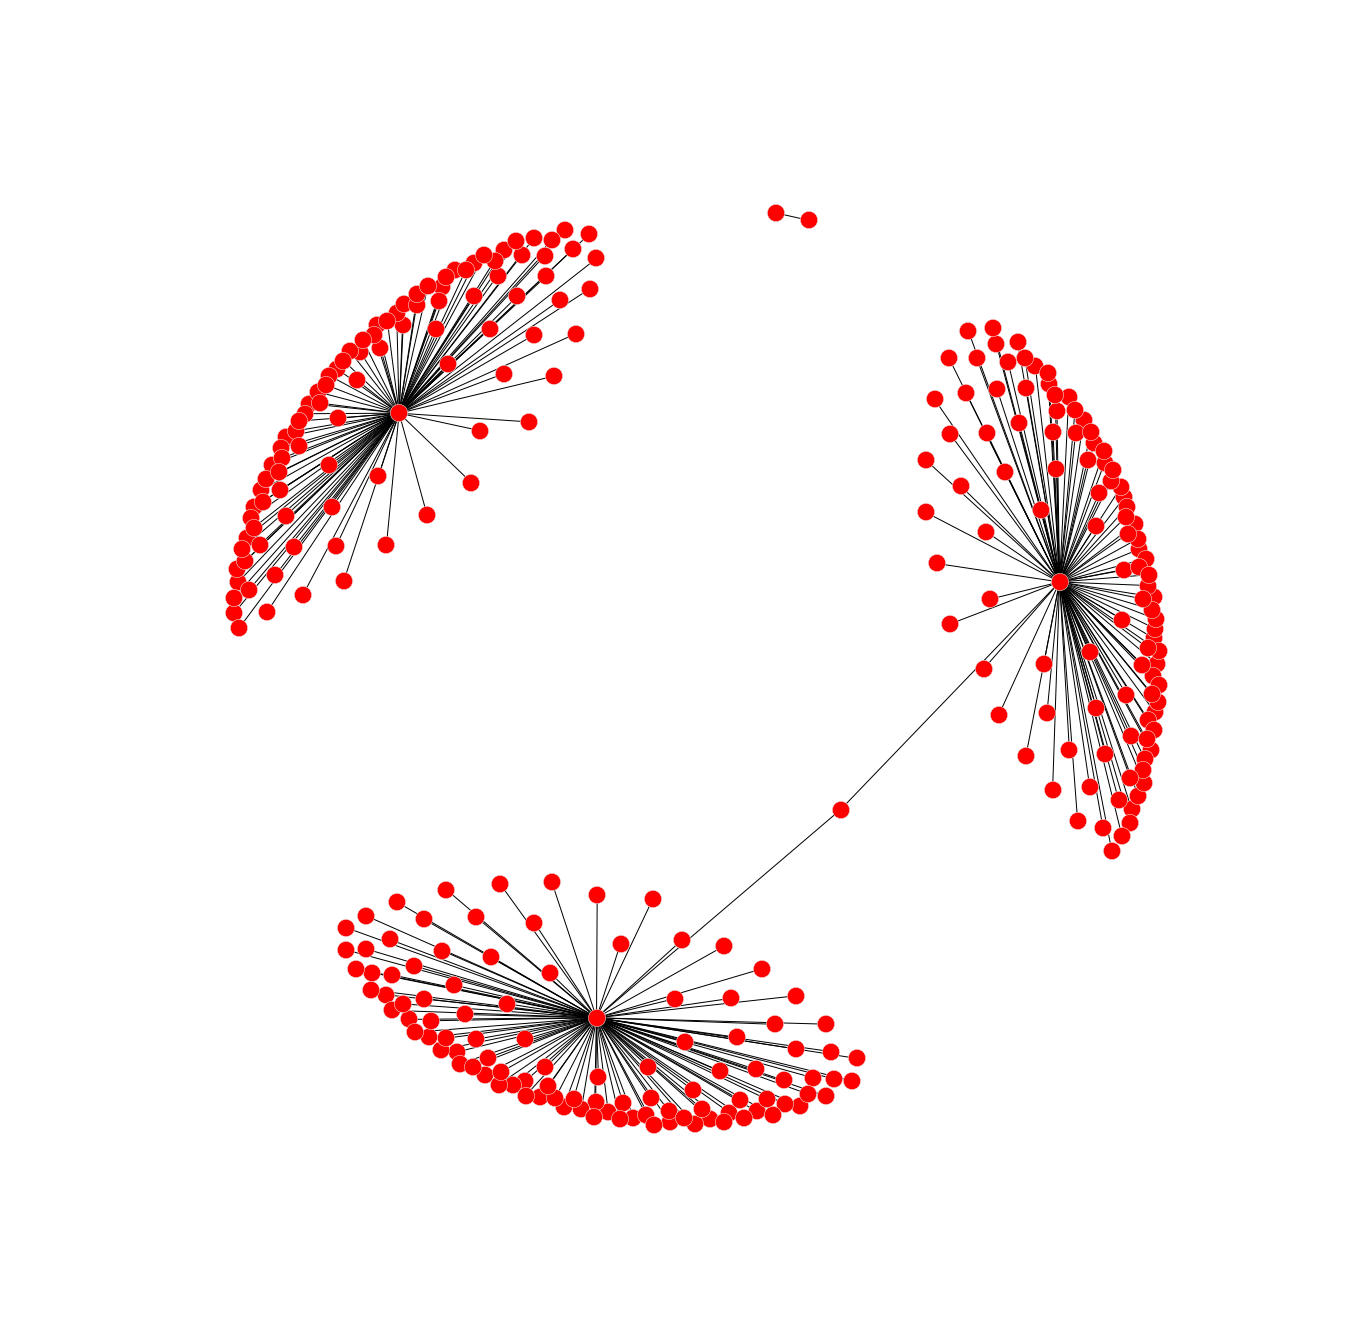

In [15]:
G = nx.Graph()
fig = plt.figure(figsize=(18,18))

def nodes(dataframe):
    for i in range(len(dataframe)):
        sender = dataframe['From'][i]
        recipient = dataframe['To'][i]
        G.add_edge(sender, recipient)

# Email network analysis of campbell, donoho and kuykendallt
# nodes(df_allenp)
nodes(df_campbell)
nodes(df_donoho)
nodes(df_kuykendallt)
# nodes(df_mcconnellm)
# nodes(df_mckayj)

nx.draw(G,pos=nx.spring_layout(G))
plt.show()

## What can be done next?
### For example, sentiment analysis
- Find a email datasets containing the sentiment classification
- Build classification model from this datasets
- Use this model to predict the email text of phillip.allen
- Get a sentiment prediction to show the emotion of phillip.allen when he wrote emails to every one in the datasets

## What can be improved?
### Many, like
- multi email addresses in 'To' column
- Remove the forward information in email main text
- parse the date
- extract more features, like identifying whether it's a reply, forward or new email.